# Fisher examples

In this notebook we will show how to perform Fisher analysis for galaxy clustering.
Look first at the notebook basic_examples.ipynb to get a flavor of *desilike* mechanisms. If you are interested in Fisher estimates for Planck likelihood, look at the notebook fisher_planck.ipynb.

## Fake BAO experiment

[000000.01] [0/1] 01-31 11:16  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.01] [0/1] 01-31 11:16  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.01] [0/1] 01-31 11:16  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.01] [0/1] 01-31 11:16  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.01] [0/1] 01-31 11:16  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1329: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


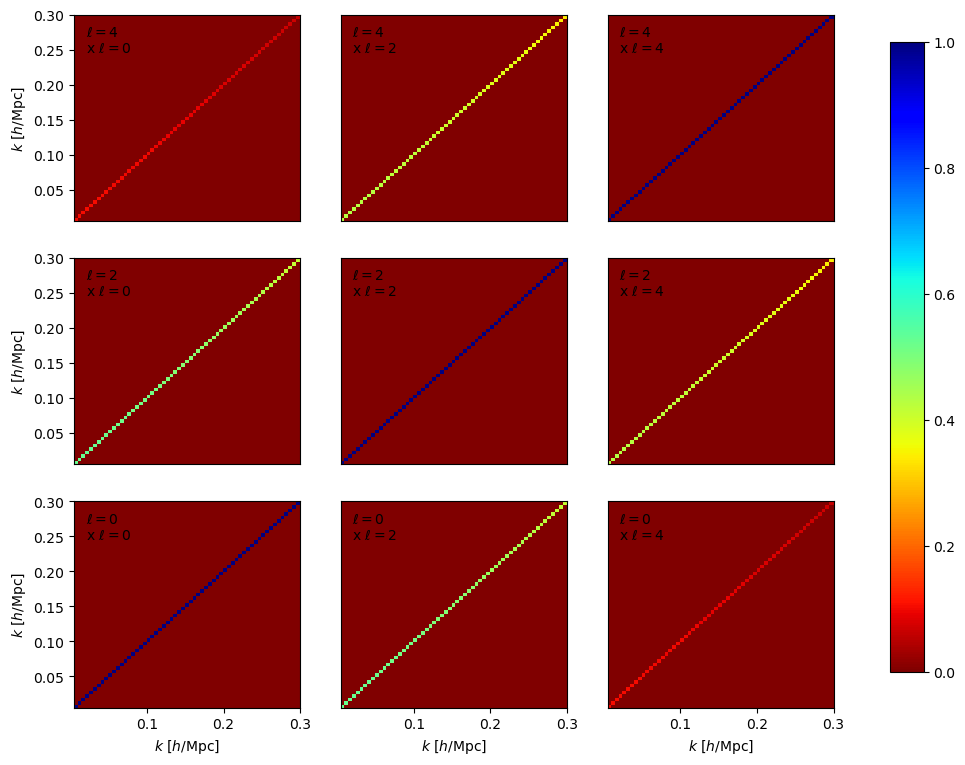

In [1]:
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, CutskyFootprint, ObservablesCovarianceMatrix
from desilike.likelihoods.galaxy_clustering import ObservablesGaussianLikelihood
from desilike import setup_logging

params = {'b1': 1.4}
footprint = CutskyFootprint(area=14000., zrange=(0.8, 1.6), nbar=(1e-3, 1e-3), cosmo=DESI())
template = BAOPowerSpectrumTemplate(z=footprint.zavg, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template)
#for param in theory.params.select(basename='a*'): param.update(fixed=True)
observable = TracerPowerSpectrumMultipolesObservable(data=params,  # data can be a dictionary of parameters
                                                     # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc, with 0.005 h/Mpc steps
                                                     klim={0: [0.005, 0.3, 0.005], 2: [0.005, 0.3, 0.005], 4: [0.005, 0.3, 0.005]},
                                                     theory=theory)


setup_logging()
covariance = ObservablesCovarianceMatrix(observable, footprints=footprint)
likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=covariance(**params))
likelihood(**params)

observable.plot_covariance_matrix(show=True);

In [2]:
from desilike import Fisher

# This prepares Fisher computation (happening when calling fisher(**params)):
# automatically detects whether derivatives can be computed with auto-differentiation, else fall back to finite differentiation
# For finite differentiation, parameter variation ranges are determined by param.delta
print('Default delta is', likelihood.all_params['qpar'].delta)
likelihood.all_params['qpar'].update(delta=0.0015)
print('New delta is', likelihood.all_params['qpar'].delta)
fisher = Fisher(likelihood)
print(likelihood.all_params.select(derived=True))
precision_bao = fisher(**params)

Default delta is (0.002, 0.002)
New delta is (0.0015, 0.0015)
[000006.46] [0/1] 01-31 11:16  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'al0_-3', 'al0_-2', 'al0_-1', 'al0_0', 'al0_1', 'al2_-3', 'al2_-2', 'al2_-1', 'al2_0', 'al2_1', 'al4_-3', 'al4_-2', 'al4_-1', 'al4_0', 'al4_1'].
[000006.59] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter qpar.
[000006.62] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter qper.
[000006.65] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000006.69] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter al0_-3.
[000006.72] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter al0_-2.
[000006.76] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter al0_-1.
[00

+-----+----------+
| FoM | 40230.79 |
+-----+----------+
+--------+--------+--------+
|        |  qpar  |  qper  |
+--------+--------+--------+
| center | 1.0000 | 1.0000 |
|  std   | 0.0075 | 0.0036 |
+--------+--------+--------+
+------+---------+---------+
|      |  qpar   |  qper   |
+------+---------+---------+
| qpar | 5.6e-5  | -1.1e-5 |
| qper | -1.1e-5 | 1.3e-5  |
+------+---------+---------+
[000010.57] [0/1] 01-31 11:16  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
[000010.92] [0/1] 01-31 11:16  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000010.92] [0/1] 01-31 11:16  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


[000011.13] [0/1] 01-31 11:16  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.14] [0/1] 01-31 11:16  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


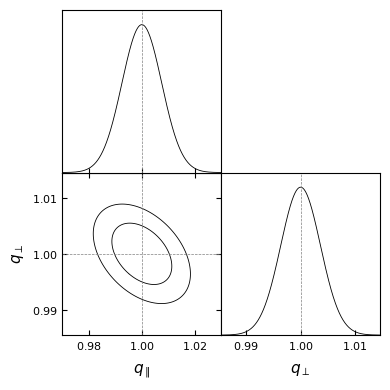

In [3]:
from desilike.samples import plotting
covariance = precision_bao.to_covariance().select(params=['qpar', 'qper'])
print(covariance.to_stats(tablefmt='pretty'))
plotting.plot_triangle(covariance, markers={'qpar': 1., 'qper': 1.})

[000011.51] [0/1] 01-31 11:16  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.51] [0/1] 01-31 11:16  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


[000011.73] [0/1] 01-31 11:16  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.74] [0/1] 01-31 11:16  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


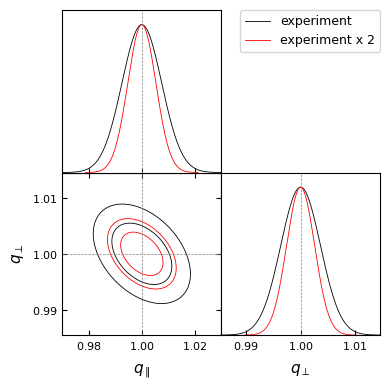

In [4]:
# One can do some fisher arithmetics, here assuming we have two independents such experiments
covariance2 = (precision_bao + precision_bao).to_covariance(params=['qpar', 'qper'])
plotting.plot_triangle([covariance, covariance2],
                        labels=['experiment', 'experiment x 2'],
                        markers={'qpar': 1., 'qper': 1.})

In [5]:
from desilike.observables.galaxy_clustering import BAOCompressionObservable
from desilike.theories.primordial_cosmology import Cosmoprimo

cosmo = Cosmoprimo(fiducial='DESI')
observable = BAOCompressionObservable(covariance=covariance, z=footprint.zavg, cosmo=cosmo)
for param in cosmo.varied_params.select(basename=['A_s', 'n_s']): param.update(fixed=True)
likelihood = ObservablesGaussianLikelihood(observables=observable)
likelihood()
    
fisher = Fisher(likelihood)
precision_bao_direct = fisher()

[000012.11] [0/1] 01-31 11:16  BAOCompressionObservable  INFO     Found BAO quantities ['qpar', 'qper'].
[000012.33] [0/1] 01-31 11:16  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'tau_reio'].
[000012.34] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter h.
[000012.36] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter omega_cdm.
[000012.37] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter omega_b.
[000012.38] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter logA.
[000012.39] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter tau_reio.
[000012.40] [0/1] 01-31 11:16  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'tau_reio'].
[000012.46] [0/1] 01-31 11:16  Differentiation   

## CMB experiment
Let's consider the Planck CMB data. Here we will use the Planck covariance matrices, but if one wants to perform Fisher forecasts far from Planck bestfit, it is better to use either Fisher matrix, or Taylor expand theory Cl's and run chains. See notebook fisher_planck.yaml.

In [6]:
from desilike.likelihoods.cmb import BasePlanck2018GaussianLikelihood

cosmo = Cosmoprimo(fiducial='DESI')
likelihood = BasePlanck2018GaussianLikelihood(cosmo=cosmo)
# Install Planck likelihoods (data)
from desilike import Installer
installer = Installer(user=True)
installer(likelihood)
likelihood()

[000013.56] [0/1] 01-31 11:16  ParameterCovariance       INFO     Loading stats file: /home/adematti/.local/data/BasePlanck2018GaussianLikelihood/base/plikHM_TTTEEE_lowl_lowE_lensing/dist/base_plikHM_TTTEEE_lowl_lowE_lensing.margestats.
[000013.57] [0/1] 01-31 11:16  Install                   INFO     Requirement already satisfied: cosmoprimo in /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo
[000013.57] [0/1] 01-31 11:16  BaseConfig                INFO     Saving /home/adematti/.desilike/config.yaml.


DeviceArray(-1.27605968, dtype=float64)

In [7]:
fisher = Fisher(likelihood)
precision_planck = fisher()

[000014.06] [0/1] 01-31 11:16  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'tau_reio'].
[000014.08] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter h.
[000014.10] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter omega_cdm.
[000014.12] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter omega_b.
[000014.13] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter logA.
[000014.15] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter n_s.
[000014.16] [0/1] 01-31 11:16  Differentiation           INFO     Using auto-differentiation for parameter tau_reio.
[000014.17] [0/1] 01-31 11:16  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'tau_reio'].
[000014.20] [0/1] 01-31 11:1

+-----+----------------------+
| FoM | 70405970698950520.00 |
+-----+----------------------+
+--------+--------+-----------+---------+-------+--------+----------+
|        |   h    | omega_cdm | omega_b | logA  |  n_s   | tau_reio |
+--------+--------+-----------+---------+-------+--------+----------+
| center | 0.6736 |  0.1200   | 0.02237 | 3.036 | 0.9649 |  0.0544  |
|  std   | 0.0054 |  0.0012   | 0.00015 | 0.014 | 0.0042 |  0.0073  |
+--------+--------+-----------+---------+-------+--------+----------+
+-----------+---------+-----------+---------+---------+---------+----------+
|           |    h    | omega_cdm | omega_b |  logA   |   n_s   | tau_reio |
+-----------+---------+-----------+---------+---------+---------+----------+
|     h     | 2.9e-5  |  -6.0e-6  | 5.5e-7  | 2.1e-5  | 1.5e-5  |  1.6e-5  |
| omega_cdm | -6.0e-6 |  1.4e-6   | -9.0e-8 | -4.1e-6 | -3.3e-6 | -3.4e-6  |
|  omega_b  | 5.5e-7  |  -9.0e-8  | 2.1e-8  | 5.0e-7  | 2.4e-7  |  3.0e-7  |
|   logA    | 2.1e-5  |  

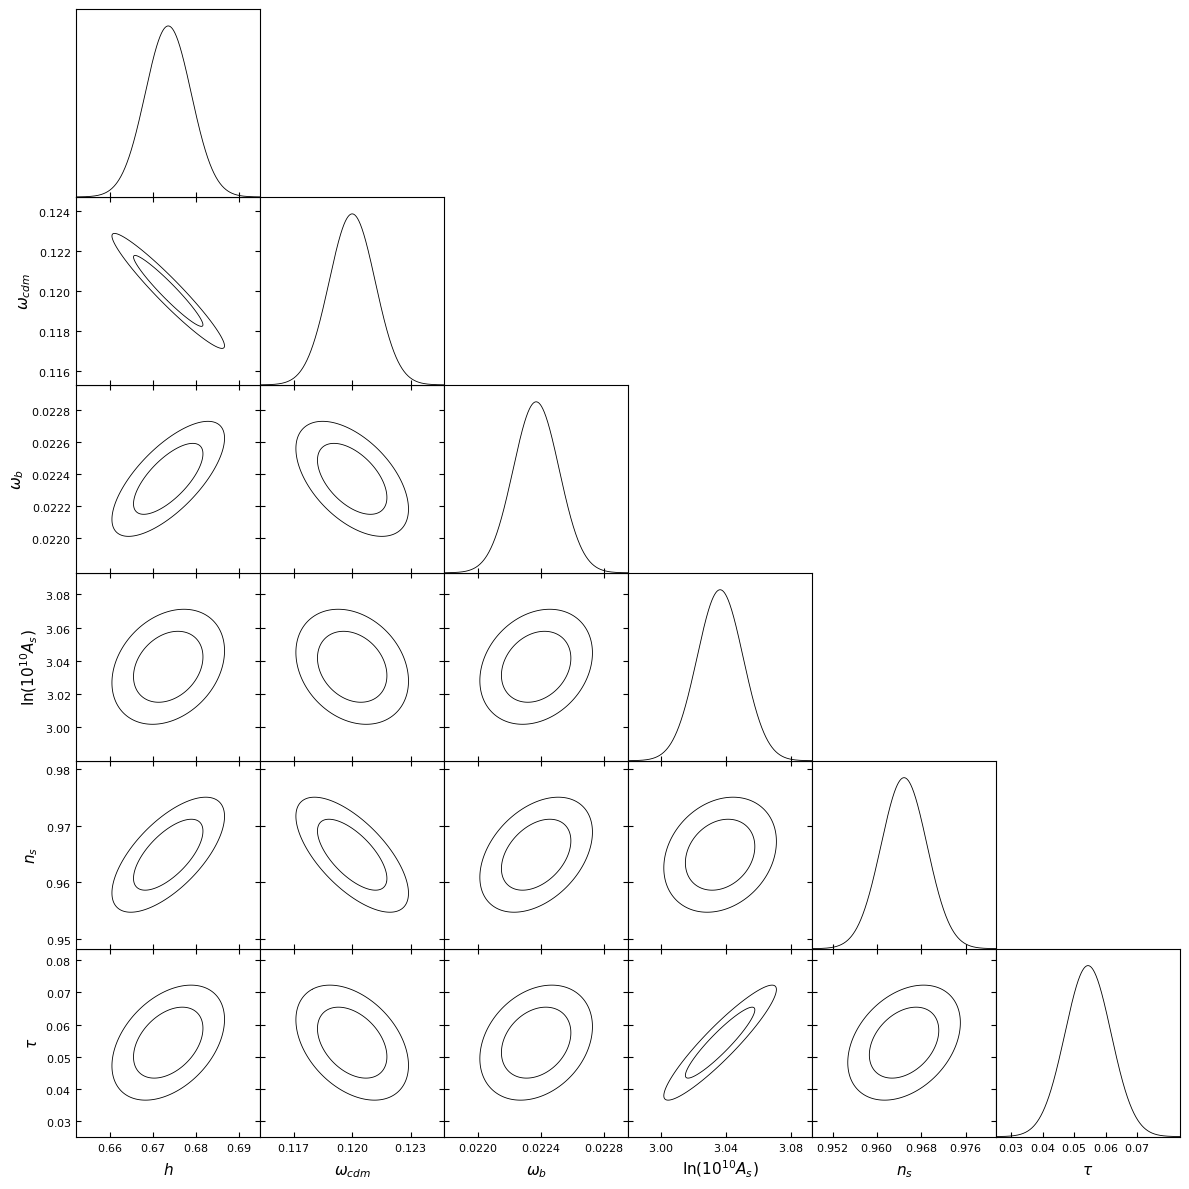

In [8]:
covariance = precision_planck.to_covariance()
print(covariance.to_stats(tablefmt='pretty'))
plotting.plot_triangle(precision_planck.to_covariance())

## Combining BAO and CMB experiments

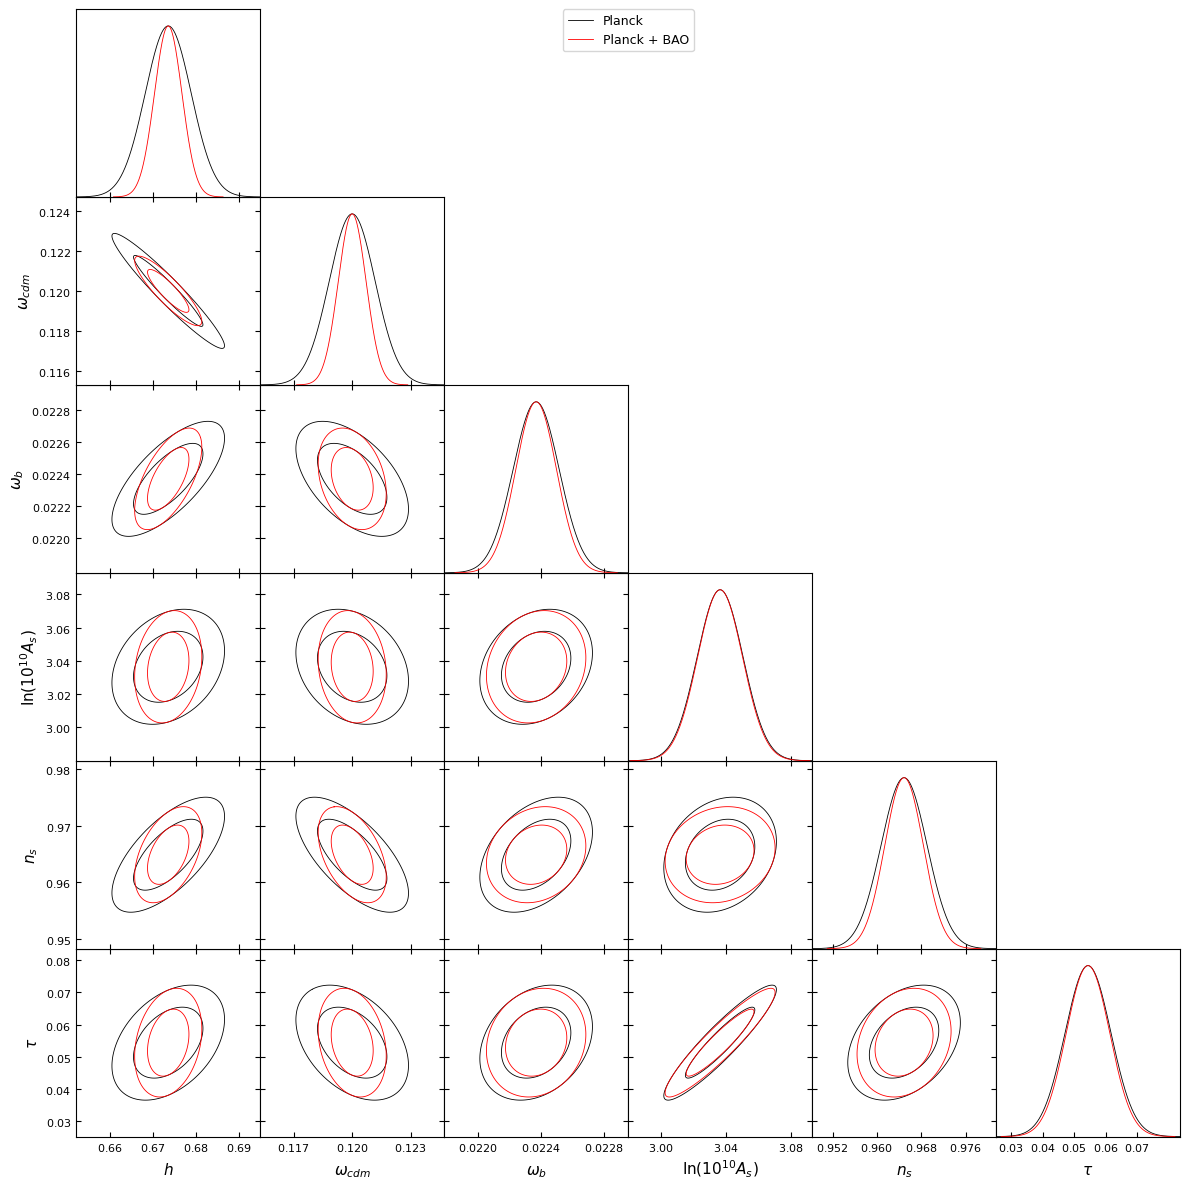

In [9]:
plotting.plot_triangle([precision_planck.to_covariance(), (precision_planck + precision_bao_direct).to_covariance()],
                       labels=['Planck', 'Planck + BAO'])

We have had very fast results, now we can run some checks!

## Comparing BAO experiment with ideal SN-weighted measurement

In [10]:
from desilike.likelihoods.galaxy_clustering import SNWeightedPowerSpectrumLikelihood

likelihood = SNWeightedPowerSpectrumLikelihood(theories=theory, data=params, footprints=footprint, klim=(0.005, 0.3))
fisher = Fisher(likelihood)
precision_bao2 = fisher(**params)

[000025.43] [0/1] 01-31 11:17  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'al0_-3', 'al0_-2', 'al0_-1', 'al0_0', 'al0_1', 'al2_-3', 'al2_-2', 'al2_-1', 'al2_0', 'al2_1', 'al4_-3', 'al4_-2', 'al4_-1', 'al4_0', 'al4_1'].
[000025.46] [0/1] 01-31 11:17  Differentiation           INFO     Using auto-differentiation for parameter qpar.
[000025.50] [0/1] 01-31 11:17  Differentiation           INFO     Using auto-differentiation for parameter qper.
[000025.53] [0/1] 01-31 11:17  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000025.56] [0/1] 01-31 11:17  Differentiation           INFO     Using auto-differentiation for parameter al0_-3.
[000025.60] [0/1] 01-31 11:17  Differentiation           INFO     Using auto-differentiation for parameter al0_-2.
[000025.63] [0/1] 01-31 11:17  Differentiation           INFO     Using auto-differentiation for parameter al0_-1.
[000025.66] [0/1] 01-31 11:17  Differentiation           INFO    

[000030.18] [0/1] 01-31 11:17  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000030.18] [0/1] 01-31 11:17  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
SN-weighted constraints are tighter by 1.2%, 0.8% for qpar, qper.
[000030.44] [0/1] 01-31 11:17  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000030.44] [0/1] 01-31 11:17  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


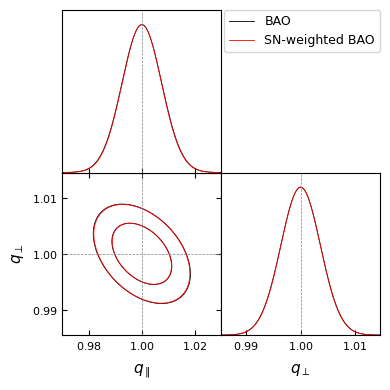

In [11]:
covariances = [precision.to_covariance(params=['qpar', 'qper']) for precision in [precision_bao, precision_bao2]]
plotting.plot_triangle(covariances, labels=['BAO', 'SN-weighted BAO'], markers={'qpar': 1., 'qper': 1.})
# We see SN-weighted constraints are slightly tighter
print('SN-weighted constraints are tighter by {0:.1%}, {1:.1%} for qpar, qper.'.format(*(covariances[0].std() / covariances[1].std() - 1.)))